In [21]:
using DataInterpolations: SmoothArcLengthInterpolation

Random.seed!(1)

n = 4
u = rand(3, n)
A = SmoothArcLengthInterpolation(u; m = 5)

SmoothArcLengthInterpolation with 31 points
┌───────────┬─────────────┬──────────┬──────────┐
│      time │          u1 │       u2 │       u3 │
├───────────┼─────────────┼──────────┼──────────┤
│       0.0 │   0.0491718 │ 0.119079 │ 0.393271 │
│ 0.0703603 │   0.0269864 │ 0.153539 │ 0.450413 │
│  0.137097 │  0.00971137 │ 0.192336 │ 0.501846 │
│  0.203801 │ -0.00355192 │  0.23671 │ 0.549797 │
│  0.270541 │  -0.0125266 │ 0.286242 │ 0.593559 │
│  0.337314 │  -0.0172039 │  0.34013 │  0.63265 │
│  0.407777 │  -0.0175421 │ 0.400798 │ 0.668408 │
│  0.478301 │  -0.0138159 │ 0.464221 │ 0.698958 │
│     ⋮     │      ⋮      │    ⋮     │    ⋮     │
│   1.03979 │    0.204067 │ 0.911244 │ 0.824877 │
│   1.09888 │    0.257848 │ 0.887916 │ 0.826758 │
│   1.15943 │    0.307302 │ 0.853081 │ 0.826189 │
│   1.25314 │    0.372683 │ 0.786276 │ 0.821875 │
│   1.34719 │    0.432338 │ 0.713833 │ 0.815967 │
│   1.47879 │    0.507208 │ 0.606141 │ 0.805672 │
│   1.61049 │    0.577164 │ 0.495155 │ 0.794274 │
│   1.

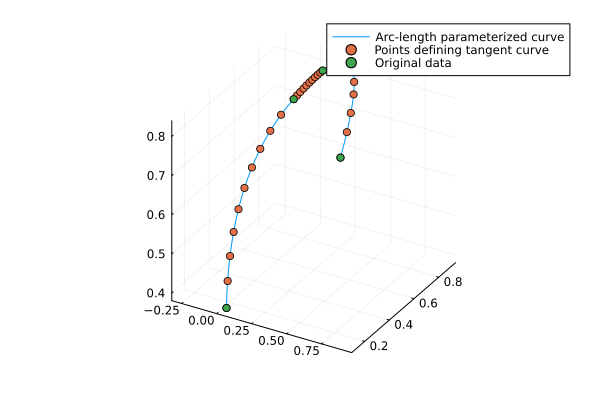

In [22]:
n_eval = 500
t_eval = range(0, last(A.t), n_eval)
u_eval = zeros(3, n_eval)

for (i, t) in enumerate(t_eval)
    u_eval[:, i] = A(t)
end

p = plot(; aspect_ratio = :equal)

plot!(u_eval[1, :], u_eval[2, :], u_eval[3, :]; label = "Arc-length parameterized curve")
scatter!(A.u[1, :], A.u[2, :], A.u[3, :]; label = "Points defining tangent curve")
scatter!(u[1, :], u[2, :], u[3, :]; label = "Original data")

p

It would be nice to have a rigorous proof of $\tilde{\gamma}$ converging to the arc-length reparametrization of $\gamma$ as $m \rightarrow \infty$ (and how fast). For now we can look at the convergence of the arc-length of $\tilde{\gamma}$ to the arc-length of $\gamma$ with $m$ for the example above: 

In [23]:
M = 5:1000
E = zeros(length(M))

(; shape_itp) = A
t_eval = range(0, last(shape_itp.t), length = 1_000_000)
u_eval = shape_itp.(t_eval)
l = sum(norm.(diff(u_eval)))


for (i, m) in enumerate(M)
    A = SmoothArcLengthInterpolation(u; m)
    E[i] = abs(l - last(A.t))
end

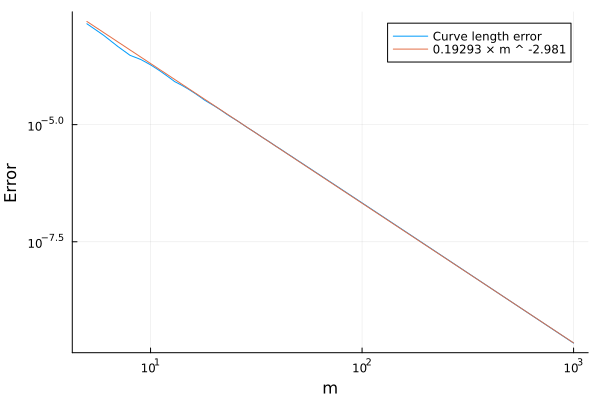

In [24]:
p = plot()
xlabel!("m")
ylabel!("Error")
plot!(M, E; xscale = :log10, yscale = :log10, label = "Curve length error")

ε = log.(E)
μ = log.(M)
k = (dot(ε, μ) - sum(ε)*sum(μ)/length(M))/(dot(μ,μ) - (sum(μ)^2)/length(M))
C = exp((sum(ε) - k*sum(μ))/length(M))


plot!(M, @. C * M^k; label = "$(round(C, digits = 5)) × m ^ $(round(k, digits = 3))")